# WEAK SCALING

In [1]:
from pyspark.sql import SparkSession
import time
import matplotlib.pyplot as plt
from datetime import datetime
import string
import json
import re

### Wrapper For Strong Scalability Testing

In [2]:
def unix_timestamp_converter(input_number):
    """
        Converts 1325376033 into 2012-12-21
    """
    return datetime.utcfromtimestamp(int(input_number)).strftime('%Y-%m-%d')


def timebody_mapper(json_object):
    """
        Converts JSON into a tuple of time and comment body
    """
    date_str = unix_timestamp_converter(json_object["created_utc"])
    body = json_object["body"]
    return (date_str, body)


def punctuation_remover(input_tuple):
    date = input_tuple[0]
    new_body = re.sub(f"[{string.punctuation}]+", " ", input_tuple[1])
    return (date, new_body.lower())


def sentence_filter(input_tuple):
    """
        Remove records that do not contain any important words
    """
    important_words = ["btc", "bitcoin", "cryptocurrency", "crypto"]
    return any([word in input_tuple[1] for word in important_words])

In [3]:
def WeakScaling(num_cores):
    spark_session = SparkSession.builder\
        .master("spark://192.168.2.133:7077")\
        .appName(f"Group8_weak_scaling_{num_cores}_core")\
        .config("spark.executor.memory", "2500m")\
        .config("spark.cores.max", num_cores)\
        .getOrCreate()
    
    spark_context = spark_session.sparkContext
    
    # Import data
    rdd = spark_context.textFile("hdfs://192.168.2.133:9000/user/root/reddit_data/RC_2012-01")

    # Sample ratio (%)
    # Changes depending on number of cores used s.t. workload is constant
    ratio = num_cores / 8
    comments_sampled = rdd.sample(False, ratio, 81)

    # Perform an action in order for dataset to really be imported
    # Otherwise the importing will be performed in the next data
    # processing part where the execution time is measured
    # (which is not desired)
    print(comments_sampled.count())
    
    start_time = time.time()
    ###########################

    # Map the data to json object
    comments_json = comments_sampled.map(json.loads)

    # Remove everything except Date and Body
    timebody_pairs = comments_json.map(timebody_mapper)
    
    # Replace punctauation with sapce
    punctuation_removed = timebody_pairs.map(punctuation_remover)

    # Tokenize
    tokenized_rdd = punctuation_removed.map(lambda x: (x[0], x[1].split()))

    # Remove sentences that don't contain any of the given words
    filtered_rdd = tokenized_rdd.filter(sentence_filter)

    # Aggregate by day
    daily_comment_counts = filtered_rdd.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b)
    
    # Just to make the RDD be evaluated
    daily_comment_counts.count()
    ###########################
    
    elapsed = time.time() - start_time
    print(f"Execution time: {elapsed}")
    
    spark_session.stop()
    
    return elapsed

### Weak Scaling 1 Core (1 Node and 12.5% of data used)

In [4]:
core_1_time = WeakScaling(1)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/24 15:09:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/24 15:09:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


2042955


Execution time: 92.08197212219238


### Weak Scaling 2 Core (2 Nodes and 25% of data used)

In [5]:
core_2_time = WeakScaling(2)

23/03/24 15:11:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


4084786


Execution time: 84.16361784934998


### Weak Scaling 4 Core (4 Nodes and 50% of data used)

In [6]:
core_4_time = WeakScaling(4)

23/03/24 15:14:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


8171704


Execution time: 87.64167213439941


### Weak Scaling 8 Core (4 Nodes and 100% of data used)

In [7]:
core_8_time = WeakScaling(8)

23/03/24 15:16:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


16350205


Execution time: 92.47353148460388


### PLOT WEAK SCALING (EFFICIENCY) GRAPH

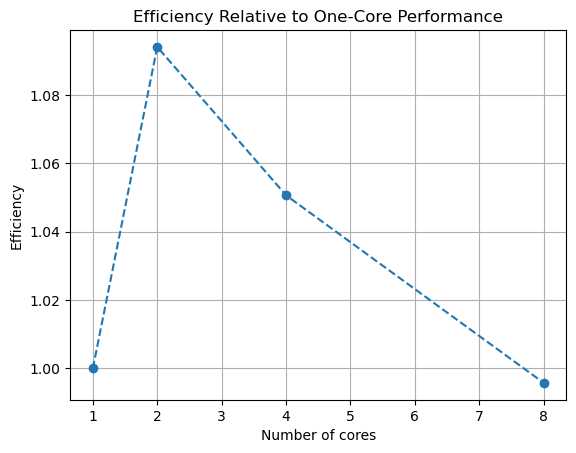

In [10]:
times = [core_1_time, core_2_time, core_4_time, core_8_time]
cores = [1, 2, 4, 8]

efficiency = [0] * 4

for i in range(len(times)):
    efficiency[i] = times[0]/times[i]

plt.plot(cores, efficiency, "--o")
plt.xlabel("Number of cores")
plt.ylabel("Efficiency")
plt.title("Efficiency Relative to One-Core Performance")
plt.grid()
plt.show()